<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulating step 0/3650 (0.0%)... Cautious: 75 | Readthrough: 75 | Inactive: 0
Simulating step 3/3650 (0.1%)... Cautious: 150 | Readthrough: 150 | Inactive: 0
Simulating step 6/3650 (0.2%)... Cautious: 300 | Readthrough: 300 | Inactive: 0
Simulating step 9/3650 (0.2%)... Cautious: 300 | Readthrough: 300 | Inactive: 0
Simulating step 12/3650 (0.3%)... Cautious: 600 | Readthrough: 600 | Inactive: 0
Simulating step 15/3650 (0.4%)... Cautious: 600 | Readthrough: 600 | Inactive: 0
Simulating step 18/3650 (0.5%)... Cautious: 1200 | Readthrough: 1200 | Inactive: 0
Simulating step 21/3650 (0.6%)... Cautious: 1200 | Readthrough: 1200 | Inactive: 0
Simulating step 24/3650 (0.7%)... Cautious: 2400 | Readthrough: 2400 | Inactive: 0
Simulating step 27/3650 (0.7%)... Cautious: 2400 | Readthrough: 2400 | Inactive: 0
Simulating step 30/3650 (0.8%)... Cautious: 4800 | Readthrough: 4800 | Inactive: 0
Simulating step 33/3650 (0.9%)... Cautious: 4800 | Readthrough: 4800 | Inactive: 0
Simulating step 36/365

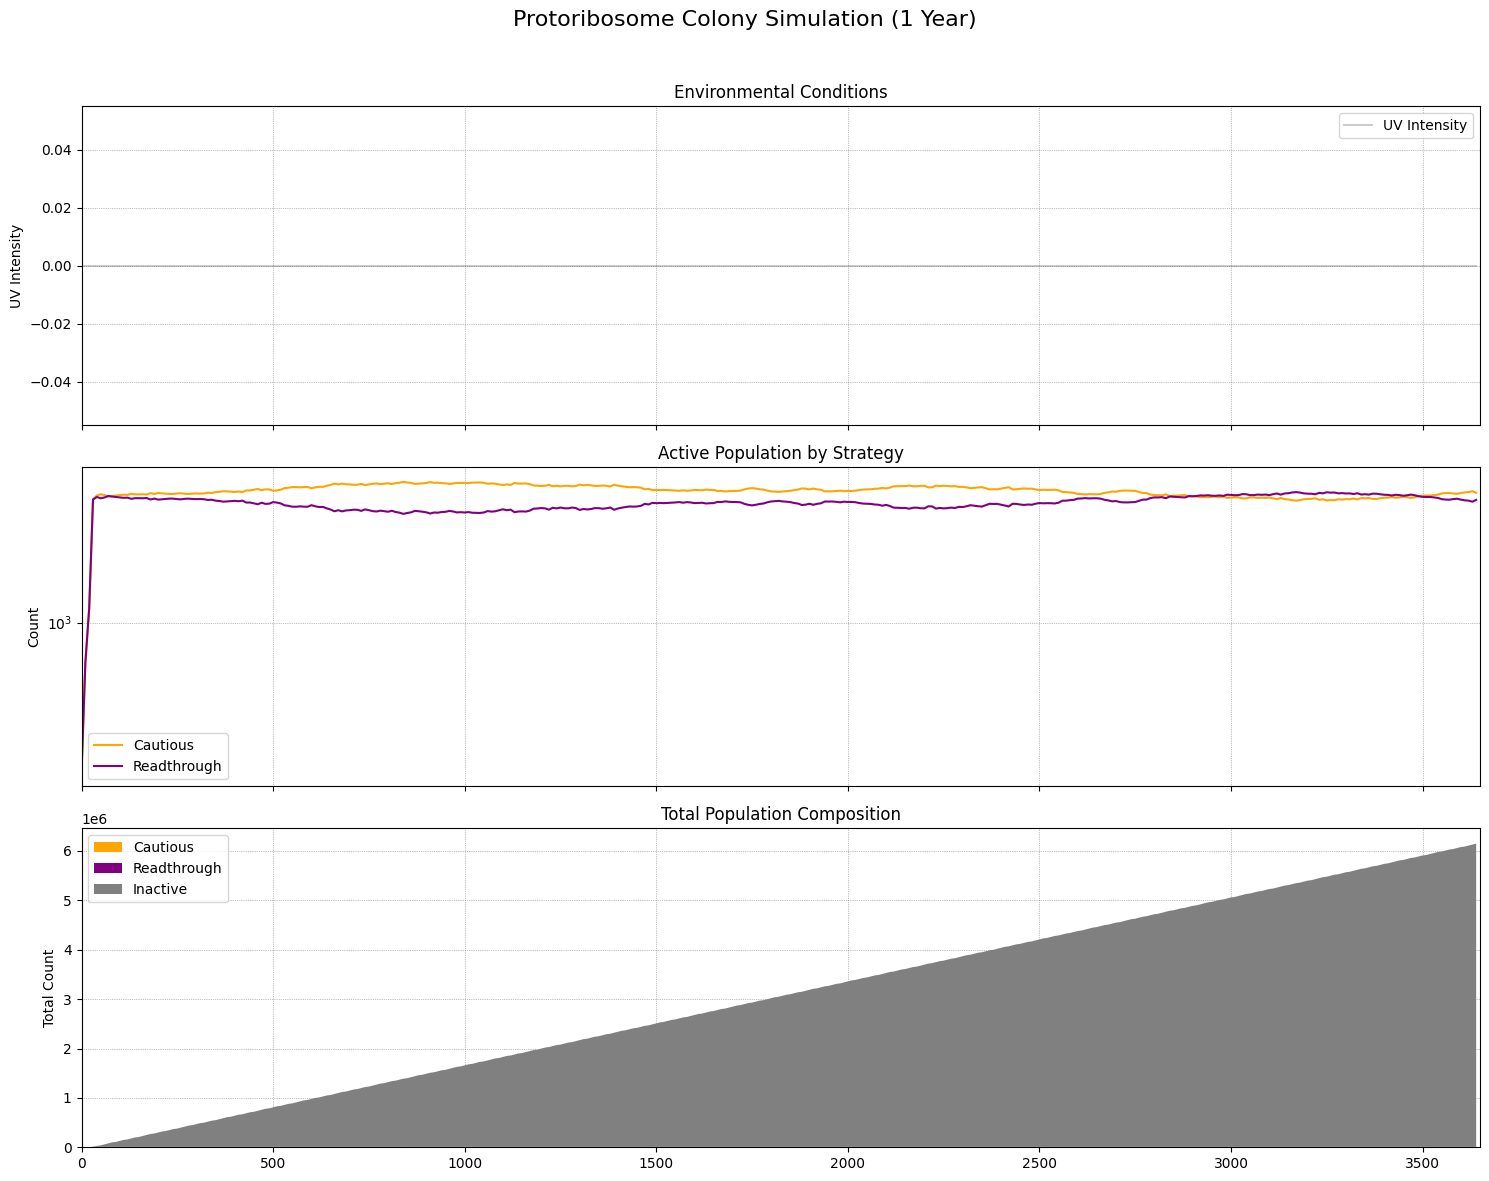

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- 1. Environment Class ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=50):
        self.total_sim_steps, self.days_per_cycle, self.time = total_sim_steps, days_per_cycle, 0
        num_years = max(1, total_sim_steps / (365 * days_per_cycle))
        steps_per_year = 365 * days_per_cycle
        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        full_uv, full_resources = [], []
        for _ in range(int(np.ceil(num_years))):
            uv_severity = np.random.uniform(0.8, 1.25)
            resource_bounty = np.random.uniform(0.8, 1.25)
            seasonal_cycle = np.sin(np.linspace(0, 2 * np.pi, steps_per_year))
            seasonal_amplitude_mod = (0.225 * seasonal_cycle + 0.725) * uv_severity
            seasonal_resource_mod = (-0.20 * seasonal_cycle + 0.80) * resource_bounty
            year_resources = 1200 * seasonal_resource_mod
            year_uv = [daily_uv_cycle[i % days_per_cycle] * seasonal_amplitude_mod[i] for i in range(steps_per_year)]
            full_uv.extend(year_uv); full_resources.extend(year_resources)
        self.uv_intensity = np.array(full_uv)[:total_sim_steps]
        self.external_resources = np.array(full_resources)[:total_sim_steps]

    def get_current_uv(self):
        return self.uv_intensity[self.time] if self.time < self.total_sim_steps else 0.0
    def get_current_resources(self):
        return self.external_resources[self.time] if self.time < self.total_sim_steps else 0.0
    def step(self):
        self.time += 1

# --- 2. Protoribosome Class ---
class Protoribosome:
    def __init__(self, env, strategy, initial_sequence, initial_mass=100.0):
        self.env, self.strategy, self.rna_sequence = env, strategy, list(initial_sequence)
        self.rna_mass = initial_mass
        self.atp_pool, self.mcyw_peptide_pool, self.other_peptide_pool = 500.0, 50.0, 5.0
        self.internal_ntp_stock, self.internal_aa_stock, self.internal_trp_tyr_cys_stock = 200.0, 200.0, 100.0
        self.rna_damage_level = 0.0

        self.location = 'dark_zone'
        self.status = 'ACTIVE'

        self.metabolic_efficiency = 1.0
        self.uv_damage_rate_per_uv = 0.75
        self.repair_rate, self.repair_atp_cost, self.trp_tyr_cys_for_repair_needed = 0.5, 0.0025, 0.0005
        self.uv_protection_factor, self.damage_tolerance_threshold = 0.01, 3.0
        self.atp_generation_rate_per_mcyw_uv, self.baseline_atp_generation_rate = 0.15, 0.5
        self.baseline_atp_chemosynthesis = 1.5
        self.protein_synthesis_rate, self.protein_synthesis_ntp_cost, self.protein_synthesis_aa_cost, self.protein_synthesis_atp_cost = 0.20, 0.1, 0.1, 0.02
        self.replication_rate, self.replication_ntp_cost, self.replication_atp_cost = 0.05, 1.0, 0.2
        self.rna_degradation_rate, self.atp_degradation_rate, self.peptide_degradation_rate = 0.0005, 0.025, 0.0008
        self.diffusion_rate, self.atp_from_ntp_conversion = 0.30, 0.1
        self.mutation_prob = 0.004
        self.failed_synthesis_penalty_atp = 100.0
        self.growth_rate = 0.1
        self.growth_ntp_cost = 1.0
        self.growth_atp_cost = 0.2

    def get_peptide_type(self):
        codons = ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)]
        if any(c in {'UGU', 'UGC', 'UAU', 'UAC', 'UGG'} for c in codons):
            return "MCYW"
        return "XXXX"

    def has_stop_codon(self):
        return any(c in {'UAA', 'UAG', 'UGA'} for c in ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)])

    def _decide_zone_transition(self):
        if self.location == 'dark_zone' and self.atp_pool < 450:
            self.location = 'light_zone'
        elif self.location == 'light_zone' and self.rna_damage_level > self.damage_tolerance_threshold * 0.75:
            self.location = 'dark_zone'

    def _apply_uv_damage(self, current_uv):
        if self.location == 'dark_zone' or current_uv <= 0:
            self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate * 0.1)
            return

        protection = self.mcyw_peptide_pool * self.uv_protection_factor
        effective_uv = current_uv * max(0.01, 1 - protection)
        self.rna_damage_level += effective_uv * self.uv_damage_rate_per_uv

        for i in range(len(self.rna_sequence)):
            if random.random() < self.mutation_prob * effective_uv:
                self.rna_sequence[i] = random.choice("AUGC")

    def _manage_state(self, has_stop_codon_cached):
        if self.atp_pool < 0.1 or self.rna_damage_level >= self.damage_tolerance_threshold:
            self.status = 'INACTIVE'
            return

        if self.strategy == 'cautious' and has_stop_codon_cached:
            self.status = 'ARRESTED'
            self.metabolic_efficiency = 1.0
        else:
            self.status = 'ACTIVE'
            self.metabolic_efficiency = 1.25

    def _synthesize_protein(self, has_stop_codon_cached):
        if self.status != 'ACTIVE': return
        units = self.protein_synthesis_rate * self.metabolic_efficiency * 10
        required_ntp = units * self.protein_synthesis_ntp_cost
        required_atp = units * self.protein_synthesis_atp_cost
        required_aa_total = units * self.protein_synthesis_aa_cost

        is_mcyw = self.get_peptide_type() == "MCYW" and not (self.strategy == 'readthrough' and has_stop_codon_cached)

        if is_mcyw:
            required_special_aa = required_aa_total * 0.5
            required_general_aa = required_aa_total - required_special_aa
            if (self.internal_ntp_stock < required_ntp or
                self.atp_pool < required_atp or
                self.internal_aa_stock < required_general_aa or
                self.internal_trp_tyr_cys_stock < required_special_aa):
                return
        else:
            required_general_aa = required_aa_total
            required_special_aa = 0
            if (self.internal_ntp_stock < required_ntp or
                self.atp_pool < required_atp or
                self.internal_aa_stock < required_general_aa):
                return

        self.internal_ntp_stock -= required_ntp
        self.atp_pool -= required_atp
        self.internal_aa_stock -= required_general_aa
        self.internal_trp_tyr_cys_stock -= required_special_aa

        if is_mcyw:
            self.mcyw_peptide_pool += units
        else:
            self.other_peptide_pool += units
            if self.strategy == 'readthrough' and has_stop_codon_cached:
                self.atp_pool -= self.failed_synthesis_penalty_atp

    def _replicate_rna(self):
        if self.status != 'ACTIVE' or self.rna_mass < 80: return None

        can_replicate = self.rna_mass * self.replication_rate * self.metabolic_efficiency

        if self.internal_ntp_stock > self.replication_ntp_cost and self.atp_pool > self.replication_atp_cost and can_replicate > 1.0:
            offspring_mass = self.rna_mass * 0.5
            self.rna_mass -= offspring_mass

            self.internal_ntp_stock -= offspring_mass * self.replication_ntp_cost
            self.atp_pool -= offspring_mass * self.replication_atp_cost
            return Protoribosome(self.env, self.strategy, "".join(self.rna_sequence), offspring_mass)
        return None

    def _repair_rna_dna(self, dna_template, has_stop_codon_cached):
        if self.status != 'ACTIVE' or self.get_peptide_type() != 'MCYW' or has_stop_codon_cached:
            return

        if "".join(self.rna_sequence) != dna_template:
            for i in range(len(self.rna_sequence)):
                if self.rna_sequence[i] != dna_template[i]:
                    if self.atp_pool >= self.repair_atp_cost and self.internal_trp_tyr_cys_stock >= self.trp_tyr_cys_for_repair_needed:
                        self.atp_pool -= self.repair_atp_cost
                        self.internal_trp_tyr_cys_stock -= self.trp_tyr_cys_for_repair_needed
                        self.rna_sequence[i] = dna_template[i]
                        self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate)
                    break

    def _diffuse_resources(self):
        available = self.env.get_current_resources()
        if available > 0:
            amount = available * self.diffusion_rate
            self.internal_ntp_stock += amount * 0.50
            self.internal_aa_stock += amount * 0.45
            self.internal_trp_tyr_cys_stock += amount * 0.05

    def _grow_mass(self):
        if self.status != 'ACTIVE': return

        potential_growth = self.rna_mass * self.growth_rate * self.metabolic_efficiency
        ntp_cost = potential_growth * self.growth_ntp_cost
        atp_cost = potential_growth * self.growth_atp_cost

        if self.internal_ntp_stock >= ntp_cost and self.atp_pool >= atp_cost:
            self.internal_ntp_stock -= ntp_cost
            self.atp_pool -= atp_cost
            self.rna_mass += potential_growth

    def step(self, current_uv, dna_template):
        if self.status == 'INACTIVE': return None

        has_stop = self.has_stop_codon()

        self._decide_zone_transition()
        self._apply_uv_damage(current_uv)
        self._manage_state(has_stop)

        if self.status == 'INACTIVE': return None

        self._diffuse_resources()
        self._grow_mass()

        self.atp_pool += self.baseline_atp_chemosynthesis
        self.atp_pool *= (1 - self.atp_degradation_rate)

        if self.location == 'light_zone' and current_uv > 0:
            self.atp_pool += (self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * current_uv)

        self._repair_rna_dna(dna_template, has_stop)
        self._synthesize_protein(has_stop)
        return self._replicate_rna()

# --- 3. Colony Class (MODIFIED FOR PERFORMANCE) ---
class Colony:
    def __init__(self, env, dna_template, initial_pop_size=50):
        self.env = env
        self.dna_template = dna_template
        # --- NEW: Separate lists for active and inactive members ---
        self.active_population = [Protoribosome(env, 'cautious' if i%2==0 else 'readthrough', dna_template) for i in range(initial_pop_size)]
        self.inactive_population = []
        self.max_population = 10000

    def step(self):
        newly_replicated = []
        current_uv = self.env.get_current_uv()

        next_active_population = []
        # --- OPTIMIZATION: Loop only iterates over active population ---
        for protoribosome in self.active_population:
            new_offspring = protoribosome.step(current_uv, self.dna_template)

            if protoribosome.status == 'INACTIVE':
                self.inactive_population.append(protoribosome)
            else:
                next_active_population.append(protoribosome)

            if new_offspring:
                newly_replicated.append(new_offspring)

        self.active_population = next_active_population
        self.active_population.extend(newly_replicated)

        # Cap the active population, moving excess to inactive
        if len(self.active_population) > self.max_population:
            random.shuffle(self.active_population)
            excess = self.active_population[self.max_population:]
            for p in excess:
                p.status = 'INACTIVE' # Make them inactive before moving
            self.inactive_population.extend(excess)
            self.active_population = self.active_population[:self.max_population]

    def get_aggregated_data(self):
        data = { 'cautious': 0, 'readthrough': 0, 'in_light_zone': 0 }
        for p in self.active_population:
            if p.strategy == 'cautious':
                data['cautious'] += 1
            else: # readthrough
                data['readthrough'] += 1
            if p.location == 'light_zone':
                data['in_light_zone'] += 1
        data['inactive'] = len(self.inactive_population)
        return data

# --- 4. Simulation and Plotting ---
def run_and_plot():
    SIMULATION_DAYS = 365
    STEPS_PER_DAY = 10
    TOTAL_STEPS = SIMULATION_DAYS * STEPS_PER_DAY

    IDEAL_DNA_TEMPLATE = "AUGUGUUACUGG"

    env = Environment(TOTAL_STEPS, STEPS_PER_DAY)
    colony = Colony(env, IDEAL_DNA_TEMPLATE, initial_pop_size=150)

    data = []
    print_interval = max(1, TOTAL_STEPS / 1000)

    for i in range(TOTAL_STEPS):
        if i % int(print_interval) == 0:
            agg_data = colony.get_aggregated_data()
            cautious_pop = agg_data.get('cautious', 0)
            readthrough_pop = agg_data.get('readthrough', 0)
            inactive_pop = agg_data.get('inactive', 0)

            print(f"Simulating step {i}/{TOTAL_STEPS} ({(i/TOTAL_STEPS)*100:.1f}%)... "
                  f"Cautious: {cautious_pop} | "
                  f"Readthrough: {readthrough_pop} | "
                  f"Inactive: {inactive_pop}")

            if i > 200 and (cautious_pop + readthrough_pop == 0):
                print("Active population extinct. Ending simulation early.")
                break

        colony.step()

        if i % STEPS_PER_DAY == 0:
            agg_data = colony.get_aggregated_data()
            log_entry = {'time': env.time, 'uv': env.get_current_uv()}
            log_entry.update(agg_data)
            data.append(log_entry)

        env.step()

    if not data:
        print("No data was logged. Cannot generate plots.")
        return

    results_df = pd.DataFrame(data)

    fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('Protoribosome Colony Simulation (1 Year)', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple', 'inactive': 'grey'}

    axs[0].plot(results_df['time'], results_df['uv'], color='black', alpha=0.2, label='UV Intensity')
    axs[0].set_title('Environmental Conditions'); axs[0].set_ylabel('UV Intensity'); axs[0].legend()

    axs[1].plot(results_df['time'], results_df['cautious'], label='Cautious', color=colors['cautious'])
    axs[1].plot(results_df['time'], results_df['readthrough'], label='Readthrough', color=colors['readthrough'])
    axs[1].set_title('Active Population by Strategy'); axs[1].set_ylabel('Count'); axs[1].legend()
    axs[1].set_yscale('symlog')

    axs[2].stackplot(results_df['time'],
                     results_df['cautious'],
                     results_df['readthrough'],
                     results_df['inactive'],
                     labels=['Cautious', 'Readthrough', 'Inactive'],
                     colors=[colors['cautious'], colors['readthrough'], colors['inactive']])
    axs[2].set_title('Total Population Composition'); axs[2].set_ylabel('Total Count'); axs[2].legend(loc='upper left')

    for ax in axs:
        ax.grid(True, linestyle=':', linewidth='0.5', color='gray')
        ax.set_xlim(0, TOTAL_STEPS)

    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

if __name__ == "__main__":
    run_and_plot()
